In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cat-dataset/CAT_03/00000811_011.jpg.cat
/kaggle/input/cat-dataset/CAT_03/00000806_008.jpg
/kaggle/input/cat-dataset/CAT_03/00000886_026.jpg.cat
/kaggle/input/cat-dataset/CAT_03/00000845_017.jpg
/kaggle/input/cat-dataset/CAT_03/00000873_028.jpg
/kaggle/input/cat-dataset/CAT_03/00000894_008.jpg.cat
/kaggle/input/cat-dataset/CAT_03/00000820_002.jpg.cat
/kaggle/input/cat-dataset/CAT_03/00000867_010.jpg.cat
/kaggle/input/cat-dataset/CAT_03/00000832_024.jpg.cat
/kaggle/input/cat-dataset/CAT_03/00000872_015.jpg.cat
/kaggle/input/cat-dataset/CAT_03/00000810_028.jpg.cat
/kaggle/input/cat-dataset/CAT_03/00000850_027.jpg.cat
/kaggle/input/cat-dataset/CAT_03/00000893_026.jpg.cat
/kaggle/input/cat-dataset/CAT_03/00000887_028.jpg
/kaggle/input/cat-dataset/CAT_03/00000817_006.jpg
/kaggle/input/cat-dataset/CAT_03/00000889_002.jpg
/kaggle/input/cat-dataset/CAT_03/00000877_022.jpg
/kaggle/input/cat-dataset/CAT_03/00000855_010.jpg
/kaggle/input/cat-dataset/CAT_03/00000827_025.jpg.cat
/kaggl

In [29]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [30]:
# transformations for the dataset
transform = transforms.Compose([
    transforms.Resize(64),  # Resize images to 64x64
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

In [31]:
dataset_path = '/kaggle/input/cat-dataset'

# Load the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Create a DataLoader for the dataset
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

In [32]:
print(f"Number of images in dataset: {len(dataset)}")
sample_img, _ = dataset[0]
print(f"Image shape: {sample_img.shape}")

Number of images in dataset: 19994
Image shape: torch.Size([3, 64, 64])


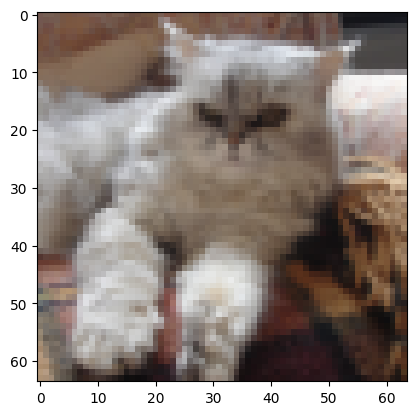

In [33]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

imshow(sample_img)

In [34]:
import torch.nn as nn
import torch.optim as optim

In [35]:
# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 3 * 64 * 64),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 3, 64, 64)  # Reshape to image dimensions
        return x

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(3 * 64 * 64, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 3 * 64 * 64)  # Flatten the image
        x = self.fc(x)
        return x

In [36]:
def train_gan(generator, discriminator, g_optimizer, d_optimizer, criterion, dataloader, num_epochs=5):
    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(dataloader):
            batch_size = images.size(0)
            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)
            
            # Train Discriminator
            discriminator.zero_grad()
            outputs = discriminator(images)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()
            
            noise = torch.randn(batch_size, 100)
            fake_images = generator(noise)
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()
            d_optimizer.step()
            
            # Train Generator
            generator.zero_grad()
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            g_optimizer.step()
            
        print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss_real.item() + d_loss_fake.item()}, g_loss: {g_loss.item()}')

# Initialize networks, optimizers, and loss function
generator = Generator()
discriminator = Discriminator()
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Train the GAN
train_gan(generator, discriminator, g_optimizer, d_optimizer, criterion, dataloader)


Epoch [1/5], d_loss: 0.30121269077062607, g_loss: 1.1051002740859985
Epoch [2/5], d_loss: 0.385190237313509, g_loss: 0.5540633201599121
Epoch [3/5], d_loss: 0.21197019517421722, g_loss: 4.951910018920898
Epoch [4/5], d_loss: 0.20228097820654511, g_loss: 4.583842754364014
Epoch [5/5], d_loss: 1.046238124370575, g_loss: 7.210995197296143


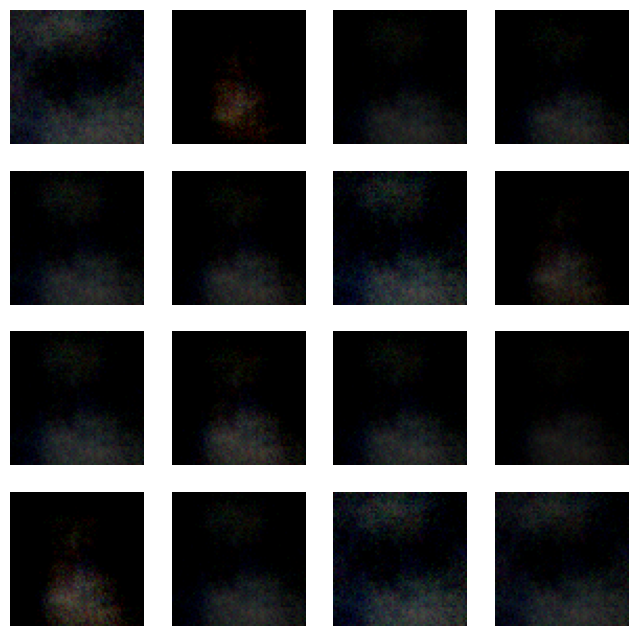

In [37]:
def generate_and_save_images(generator, num_images=16):
    noise = torch.randn(num_images, 100)
    generated_images = generator(noise).detach().numpy()
    
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(num_images):
        ax = axes[i // 4, i % 4]
        ax.imshow(generated_images[i].transpose(1, 2, 0))
        ax.axis('off')
    plt.show()

# Generate and display images
generate_and_save_images(generator)


In [38]:
import numpy as np

def display_real_and_fake_images(generator, dataloader, num_images=16):
    # Get a batch of real images
    real_images, _ = next(iter(dataloader))
    
    # Generate fake images
    noise = torch.randn(num_images, 100)
    fake_images = generator(noise).detach()

In [39]:
# Unnormalize images
def unnormalize(img):
    img = img / 2 + 0.5
    return img.clamp(0, 1)
    
    real_images = unnormalize(real_images[:num_images])
    fake_images = unnormalize(fake_images[:num_images])
    
    
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        # Plot real images
        ax = axes[0, i]
        ax.imshow(np.transpose(real_images[i].numpy(), (1, 2, 0)))
        ax.axis('off')
        
        # Plot fake images
        ax = axes[1, i]
        ax.imshow(np.transpose(fake_images[i].numpy(), (1, 2, 0)))
        ax.axis('off')
    
    plt.show()
# Display real and fake images
display_real_and_fake_images(generator, dataloader)

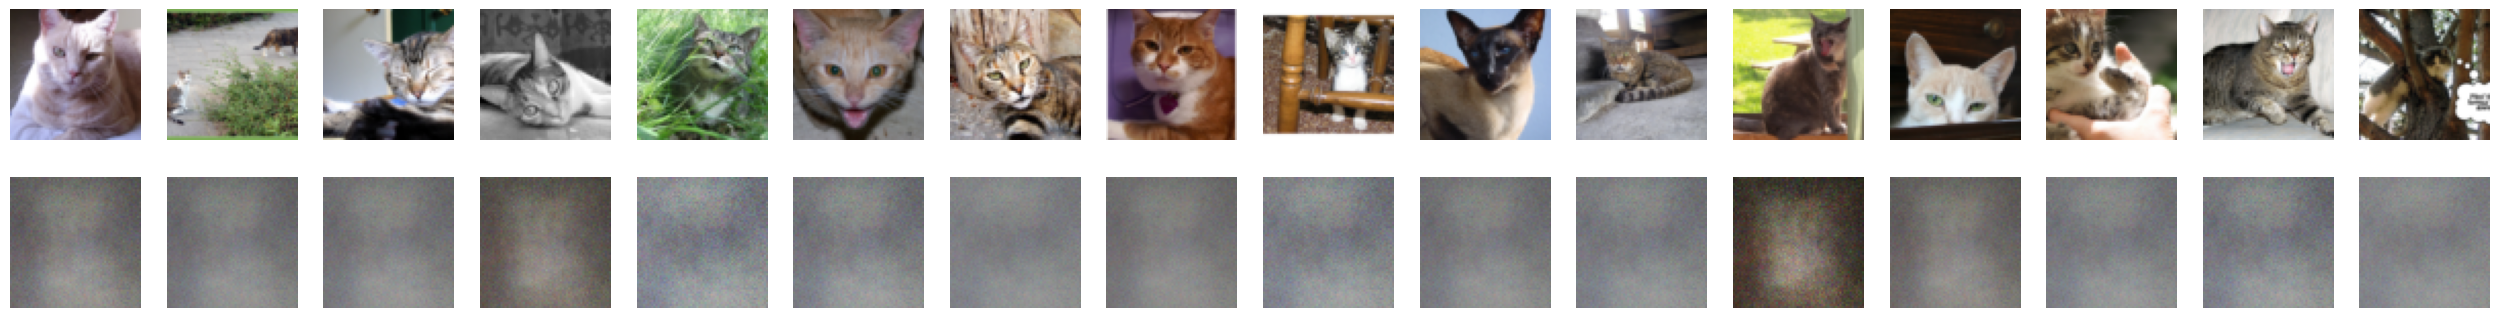

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def unnormalize(tensor, mean, std):
    """ Unnormalize an image tensor. """
    mean = torch.tensor(mean).reshape(1, 3, 1, 1)
    std = torch.tensor(std).reshape(1, 3, 1, 1)
    tensor = tensor * std + mean
    return tensor

def display_real_and_fake_images(generator, dataloader, num_images=16):
    # Get a batch of real images
    real_images, _ = next(iter(dataloader))
    
    # Generate fake images
    noise = torch.randn(num_images, 100)
    fake_images = generator(noise).detach()
    
    # Unnormalize images
    real_images = unnormalize(real_images[:num_images], mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    fake_images = unnormalize(fake_images[:num_images], mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    
    # Create a grid of images
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
    
    for i in range(num_images):
        # Plot real images
        ax = axes[0, i]
        ax.imshow(np.transpose(real_images[i].numpy(), (1, 2, 0)))
        ax.axis('off')
        
        # Plot fake images
        ax = axes[1, i]
        ax.imshow(np.transpose(fake_images[i].numpy(), (1, 2, 0)))
        ax.axis('off')
    
    plt.show()

# Display real and fake images
display_real_and_fake_images(generator, dataloader)


In [45]:
def train_gan(generator, discriminator, g_optimizer, d_optimizer, criterion, dataloader, num_epochs=5):
    g_losses = []
    d_losses = []
    
    for epoch in range(num_epochs):
        g_loss_epoch = 0
        d_loss_epoch = 0
        
        for i, (images, _) in enumerate(dataloader):
            batch_size = images.size(0)
            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)
            
            # Train Discriminator
            discriminator.zero_grad()
            outputs = discriminator(images)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()
            
            noise = torch.randn(batch_size, 100)
            fake_images = generator(noise)
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()
            d_optimizer.step()
            
            d_loss_epoch += d_loss_real.item() + d_loss_fake.item()
            
            # Train Generator
            generator.zero_grad()
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            g_optimizer.step()
            
            g_loss_epoch += g_loss.item()
        
        # Average losses for the epoch
        g_losses.append(g_loss_epoch / len(dataloader))
        d_losses.append(d_loss_epoch / len(dataloader))
        
        print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_losses[-1]}, g_loss: {g_losses[-1]}')
    
    return g_losses, d_losses

# Initialize networks, optimizers, and loss function
generator = Generator()
discriminator = Discriminator()
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Train the GAN and record losses
g_losses, d_losses = train_gan(generator, discriminator, g_optimizer, d_optimizer, criterion, dataloader, num_epochs=5)


Epoch [1/5], d_loss: 0.3877700084913689, g_loss: 2.0224195374086644
Epoch [2/5], d_loss: 0.21173227138002348, g_loss: 4.163261250280343
Epoch [3/5], d_loss: 0.22200437357893218, g_loss: 4.4308773337271266
Epoch [4/5], d_loss: 0.21312830072087474, g_loss: 5.013795875798399
Epoch [5/5], d_loss: 0.2854358620244719, g_loss: 5.618332674328131


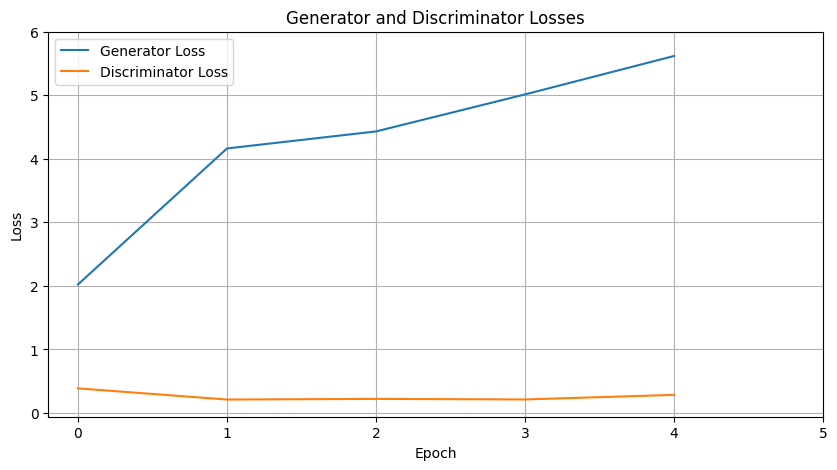

In [48]:
def plot_losses(g_losses, d_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses')
    plt.legend()
    plt.grid()
    plt.xticks(np.arange(0, len(g_losses) + 1, 1))
    plt.yticks(np.arange(0, max(max(g_losses), max(d_losses)) + 1, 1))
    plt.show()

# Plot the loss curves
plot_losses(g_losses, d_losses)

In [43]:
def train_gan_with_scores(generator, discriminator, g_optimizer, d_optimizer, criterion, dataloader, num_epochs=5):
    g_losses = []
    d_losses = []
    real_scores = []
    fake_scores = []
    
    for epoch in range(num_epochs):
        g_loss_epoch = 0
        d_loss_epoch = 0
        real_score_epoch = 0
        fake_score_epoch = 0
        
        for i, (images, _) in enumerate(dataloader):
            batch_size = images.size(0)
            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)
            
            # Train Discriminator
            discriminator.zero_grad()
            outputs = discriminator(images)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()
            
            noise = torch.randn(batch_size, 100)
            fake_images = generator(noise)
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()
            d_optimizer.step()
            
            d_loss_epoch += d_loss_real.item() + d_loss_fake.item()
            real_score_epoch += outputs.mean().item()
            
            # Train Generator
            generator.zero_grad()
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            g_optimizer.step()
            
            g_loss_epoch += g_loss.item()
            fake_score_epoch += outputs.mean().item()
        
        # Average losses and scores for the epoch
        g_losses.append(g_loss_epoch / len(dataloader))
        d_losses.append(d_loss_epoch / len(dataloader))
        real_scores.append(real_score_epoch / len(dataloader))
        fake_scores.append(fake_score_epoch / len(dataloader))
        
        print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_losses[-1]}, g_loss: {g_losses[-1]}, real_score: {real_scores[-1]}, fake_score: {fake_scores[-1]}')
    
    return g_losses, d_losses, real_scores, fake_scores

# Train the GAN and record losses and scores
g_losses, d_losses, real_scores, fake_scores = train_gan_with_scores(generator, discriminator, g_optimizer, d_optimizer, criterion, dataloader, num_epochs=5)



Epoch [1/5], d_loss: 0.48922905415153733, g_loss: 3.64335253901375, real_score: 0.17524322941185186, fake_score: 0.058340870604192775
Epoch [2/5], d_loss: 0.5231121987366257, g_loss: 3.6316729026099743, real_score: 0.18568710961376136, fake_score: 0.056449007631217046
Epoch [3/5], d_loss: 0.5388932886024633, g_loss: 3.391204509872217, real_score: 0.19106613680387077, fake_score: 0.07089561560360816
Epoch [4/5], d_loss: 0.5819986118152499, g_loss: 3.2129868280392486, real_score: 0.20660736736731408, fake_score: 0.0757702680560537
Epoch [5/5], d_loss: 0.6211506106887763, g_loss: 3.1652908523242695, real_score: 0.20968883905928737, fake_score: 0.07992546864972709


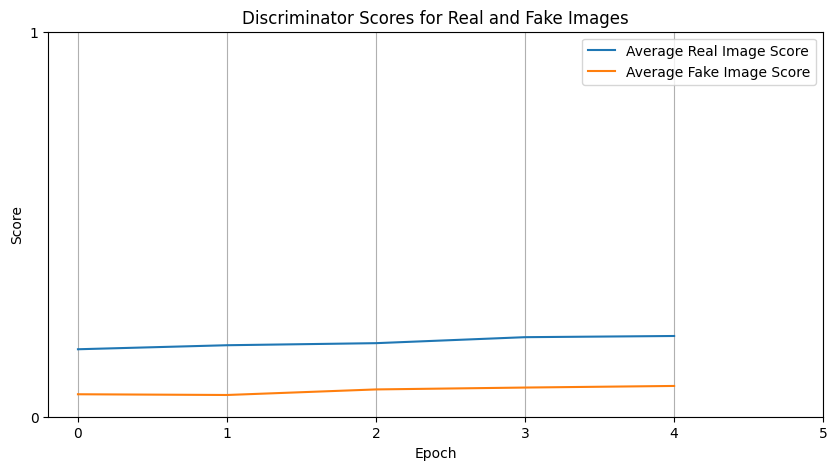

In [49]:
def plot_scores(real_scores, fake_scores):
    plt.figure(figsize=(10, 5))
    plt.plot(real_scores, label='Average Real Image Score')
    plt.plot(fake_scores, label='Average Fake Image Score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Discriminator Scores for Real and Fake Images')
    plt.legend()
    plt.grid()
    plt.xticks(np.arange(0, len(real_scores) + 1, 1))
    plt.yticks(np.arange(0, 1.1, 1))
    plt.show()

# Plot the discriminator scores
plot_scores(real_scores, fake_scores)